In [1]:
# Required imports
import numpy as np
import pandas as pd
from pathlib import Path
import os
import duckdb
import warnings
warnings.filterwarnings('ignore')
%matplotlib widget
import matplotlib.pyplot as plt
import mplcursors  

from factor_tools import create_extended_analysis_data
from backtest_tools import (
    CommissionModel, 
    FixedSlippageModel,
    BrokersModel,
    Trading,
    Backtest,
    load_distribution_data
)

In [2]:
# Strategy base class and implementations
class PortfolioStrategy:
    """Base class for portfolio generation strategies"""
    
    def generate_portfolio_targets(self, data_df, min_price=2.0, market_cap_percentile=0.05, stock_num=10, logger=print):
        """
        Generate target portfolio based on strategy logic
        
        Parameters:
        -----------
        data_df : DataFrame
            Daily stock data including factors
        min_price : float
            Minimum price threshold for stocks
        market_cap_percentile : float
            Market cap percentile threshold (0-1)
        stock_num : int
            Number of stocks to select
        logger : function
            Logging function
            
        Returns:
        --------
        dict : {symbol: target_weight}
        """
        raise NotImplementedError("Subclasses must implement generate_portfolio_targets")


class MultiFactorStrategy(PortfolioStrategy):
    """Simple strategy that uses multiple factors with equal weights"""
    """Strategy that implements the exact ranking logic from strat.txt"""
    
    def __init__(self, industry_limit=2):
        """
        Initialize strategy
        
        Parameters:
        -----------
        industry_limit : int
            Maximum number of stocks per industry
        """
        self.industry_limit = industry_limit
        
    def generate_portfolio_targets(self, data_df, min_price=2.0, market_cap_percentile=0.05, stock_num=10, logger=print):
        """Generate portfolio targets using the exact ranking approach from strat.txt"""
        try:
            # Validate data
            if data_df is None or len(data_df) == 0:
                logger("Error: Empty dataframe passed to generate_portfolio_targets")
                return {}

            # Filter universe first
            universe_df = data_df[
                (data_df['dlyprc'] > min_price) &
                (data_df['dlycap'] > data_df['dlycap'].quantile(market_cap_percentile))
            ].copy()
            
            logger(f"Starting universe size: {len(universe_df)} stocks")
            
            # Define quality factors for first stage filtering (from strat.txt)
            quality_factors = [
                'adjusted_profit_to_profit',
                'ocf_to_revenue',
                'operating_profit_to_profit',
                'net_profit_margin',
                'current_debt_to_total_debt', 
                'current_assets_to_current_debt',
                'total_asset_turnover_rate',
                'roa'
            ]
            
            # Filter for valid quality factors present in the data
            valid_quality_factors = [f for f in quality_factors if f in universe_df.columns]
            
            # STAGE 1: Quality Factors Ranking (point1)
            logger(f"Stage 1: Ranking on {len(valid_quality_factors)} quality factors")
            
            # Check if we have any valid quality factors
            if valid_quality_factors:
                # Calculate ranks for all quality factors
                ranks_df = pd.DataFrame(index=universe_df.index)
                for factor in valid_quality_factors:
                    factor_series = universe_df[factor]
                    if not factor_series.isna().all():
                        ranks_df[factor] = factor_series.rank(ascending=True, na_option='top')
                
                # Calculate point1 score
                universe_df['point1'] = ranks_df.sum(axis=1)
                
                # Sort by point1 and keep top 2/3 (as in strat.txt)
                universe_df = universe_df.sort_values('point1', ascending=False)
                cutoff_idx = int(len(universe_df) * 2/3)
                universe_df = universe_df.iloc[:cutoff_idx]
                
                logger(f"After quality filter: {len(universe_df)} stocks")
            else:
                logger("Warning: No quality factors found for Stage 1")
            
            # Early exit if no stocks remain
            if len(universe_df) == 0:
                logger("No stocks remain after Stage 1 filtering")
                return {}
            
            # Define growth factors for second stage filtering (from strat.txt)
            growth_factors = [
                'roe',
                'inc_operation_profit_year_on_year',
                'inc_net_profit_to_shareholders_year_on_year',
                'inc_net_profit_year_on_year'
            ]
            
            # Filter for valid growth factors present in the data
            valid_growth_factors = [f for f in growth_factors if f in universe_df.columns]
            
            # STAGE 2: Growth Factors Ranking (point3)
            logger(f"Stage 2: Ranking on {len(valid_growth_factors)} growth factors")
            
            # Check if we have any valid growth factors
            if valid_growth_factors:
                # Calculate ranks for all growth factors
                ranks_df = pd.DataFrame(index=universe_df.index)
                for factor in valid_growth_factors:
                    factor_series = universe_df[factor]
                    if not factor_series.isna().all():
                        ranks_df[factor] = factor_series.rank(ascending=True, na_option='top')
                
                # Calculate point3 score
                universe_df['point3'] = ranks_df.sum(axis=1)
                
                # Sort by point3 and keep top 1/2 (as in strat.txt)
                universe_df = universe_df.sort_values('point3', ascending=False)
                cutoff_idx = int(len(universe_df) * 1/2)
                universe_df = universe_df.iloc[:cutoff_idx]
                
                logger(f"After growth filter: {len(universe_df)} stocks")
            else:
                logger("Warning: No growth factors found for Stage 2")
            
            # Early exit if no stocks remain
            if len(universe_df) == 0:
                logger("No stocks remain after Stage 2 filtering")
                return {}
            
            # STAGE 3: Value and Cash Flow Factors (as in strat.txt)
            
            # Calculate BP (book-to-price) if possible
            if 'pb_ratio' in universe_df.columns:
                universe_df['bp'] = 1 / universe_df['pb_ratio']
            
            # Calculate S2EV (sales to enterprise value) if possible
            if all(col in universe_df.columns for col in ['enterprise_value', 'operating_revenue']):
                universe_df['S2EV'] = universe_df['operating_revenue'] / universe_df['enterprise_value']
            
            # point6: BP and ROE
            if all(col in universe_df.columns for col in ['bp', 'roe']):
                logger("Calculating point6 (bp and roe)")
                ranks_df = pd.DataFrame(index=universe_df.index)
                ranks_df['bp_rank'] = universe_df['bp'].rank(ascending=True, na_option='top')
                ranks_df['roe_rank'] = universe_df['roe'].rank(ascending=True, na_option='top')
                universe_df['point6'] = ranks_df.sum(axis=1)
            
            # point7: Gross Profit Margin and S2EV
            if all(col in universe_df.columns for col in ['gross_profit_margin', 'S2EV']):
                logger("Calculating point7 (gross_profit_margin and S2EV)")
                ranks_df = pd.DataFrame(index=universe_df.index)
                ranks_df['gpm_rank'] = universe_df['gross_profit_margin'].rank(ascending=True, na_option='top')
                ranks_df['s2ev_rank'] = universe_df['S2EV'].rank(ascending=True, na_option='top')
                universe_df['point7'] = ranks_df.sum(axis=1)
            
            # point10: Cash Flow Ratios
            if all(col in universe_df.columns for col in ['cash_flow_to_asset', 'cash_flow_to_liability']):
                logger("Calculating point10 (cash flow ratios)")
                ranks_df = pd.DataFrame(index=universe_df.index)
                ranks_df['cf2a_rank'] = universe_df['cash_flow_to_asset'].rank(ascending=True, na_option='top')
                ranks_df['cf2l_rank'] = universe_df['cash_flow_to_liability'].rank(ascending=True, na_option='top')
                universe_df['point10'] = ranks_df.sum(axis=1)
            
            # Calculate final point8 score (using all available point columns)
            point_columns = [col for col in ['point6', 'point7', 'point10'] if col in universe_df.columns]
            
            if point_columns:
                logger(f"Stage 3: Calculating final score from {', '.join(point_columns)}")
                # Rank each point column
                ranks_df = pd.DataFrame(index=universe_df.index)
                for col in point_columns:
                    ranks_df[f"{col}_rank"] = universe_df[col].rank(ascending=True)
                
                universe_df['point8'] = ranks_df.sum(axis=1)
                
                # Sort by point8 and keep top 1/4 (as in strat.txt)
                universe_df = universe_df.sort_values('point8', ascending=False)
                cutoff_idx = int(len(universe_df) * 1/4)
                universe_df = universe_df.iloc[:cutoff_idx]
                
                logger(f"After value/cash flow filter: {len(universe_df)} stocks")
            else:
                logger("Warning: No point columns found for Stage 3")
            
            # Early exit if no stocks remain
            if len(universe_df) == 0:
                logger("No stocks remain after Stage 3 filtering")
                return {}
            
            # First sort by market cap (smallest first) - this matches strat.txt
            # This is before industry diversification (important!)
            universe_df = universe_df.sort_values('dlycap', ascending=True)
            logger("Sorted by market cap (ascending)")
            
            '''
            # Apply industry diversification
            if 'industry_name' in universe_df.columns:
                logger("Applying industry diversification")
                # Sort by market cap (smallest first)
                universe_df = universe_df.sort_values('dlycap', ascending=True)
                
                # Calculate cumulative count per industry
                universe_df['times'] = 1
                universe_df = universe_df.reset_index()
                universe_df['sum_times'] = universe_df.groupby(['industry_name'])['times'].cumsum()
                
                # Filter to respect industry limit
                universe_df = universe_df[universe_df['sum_times'] <= self.industry_limit]
                logger(f"After industry diversification: {len(universe_df)} stocks")
                
                # Make sure we have the right index column
                if 'permno' in universe_df.columns:
                    universe_df = universe_df.set_index('permno')
            '''
            # Select final stocks (up to stock_num)
            selected_stocks = universe_df.head(stock_num).index
            
            # Equal weight portfolio
            weight = 1.0 / len(selected_stocks) if len(selected_stocks) > 0 else 0
            target_portfolio = {int(stock): weight for stock in selected_stocks}
            
            # Log portfolio construction details
            logger(f"Final portfolio: {len(target_portfolio)} stocks selected")
            return target_portfolio
            
        except Exception as e:
            logger(f"Unexpected error in generate_portfolio_targets: {str(e)}")
            import traceback
            logger(traceback.format_exc())
            return {}

In [3]:
# Define all our factors together (no need to separate them)
all_factors = [
    # Quality factors
    'adjusted_profit_to_profit',
    'ocf_to_revenue',
    'operating_profit_to_profit',
    'net_profit_margin',
    'current_debt_to_total_debt',
    'current_assets_to_current_debt',
    'total_asset_turnover_rate',
    'roa',
    
    # Growth factors
    'roe',
    'inc_operation_profit_year_on_year',
    'inc_net_profit_to_shareholders_year_on_year',
    'inc_net_profit_year_on_year',
    
    # Value factors
    'book_to_price',
    'gross_profit_margin',
    'sales_to_ev',
    'cash_flow_to_asset',
    'cash_flow_to_liability'
]

In [18]:
# Analysis parameters
ANALYSIS_PARAMS = {
    'start_date': '2015-02-01',
    'end_date': '2015-12-30',
    'factor_name': ['roe'],
    'stock_num': 50,
    'rebalance_freq': '1m'
}

In [19]:
# Load data
data_df_dic, trading_dates = create_extended_analysis_data(
    ANALYSIS_PARAMS['start_date'],
    ANALYSIS_PARAMS['end_date'],
    all_factors,
    'wrds_data.db',
    'factor_data'
)

# Load distribution data
distribution_data = load_distribution_data(
    ANALYSIS_PARAMS['start_date'],
    ANALYSIS_PARAMS['end_date']
)

# Create our strategy - just use all factors together with industry diversification
strategy = MultiFactorStrategy(
    
    industry_limit=2  # Optional: limit 2 stocks per industry
)

Processing dates: 100%|██████████| 232/232 [00:20<00:00, 11.51it/s]


In [6]:
commission_model = BrokersModel()
slippagemodel = FixedSlippageModel(0.005)

In [21]:
# Initialize and run backtest
backtest = Backtest(
    cash=10000000,  # Initial cash
    commission_model=commission_model,
    slippage_model= slippagemodel,
    data_df_dic=data_df_dic,
    trading_dates=trading_dates,
    distribution_data=distribution_data,
    factor_list=None, #ANALYSIS_PARAMS['factor_name'],
    dir_='backtest_results',
    save_format='html',
    stock_num=ANALYSIS_PARAMS.get('stock_num', 10),
    margin_rate=0.06,
    rebalance_freq=ANALYSIS_PARAMS.get('rebalance_freq', '1d'),
    rebalance_day=1,
    min_price=2.0,
    market_cap_percentile=0.25,
    #buy_and_hold_list=buy_and_hold,
    weight_change_threshold=0.08,
    strategy=strategy 
)

# No need for additional parameter setting
backtest.backtest()

Starting backtest...


100%|██████████| 231/231 [02:21<00:00,  1.64it/s]

Backtest completed.


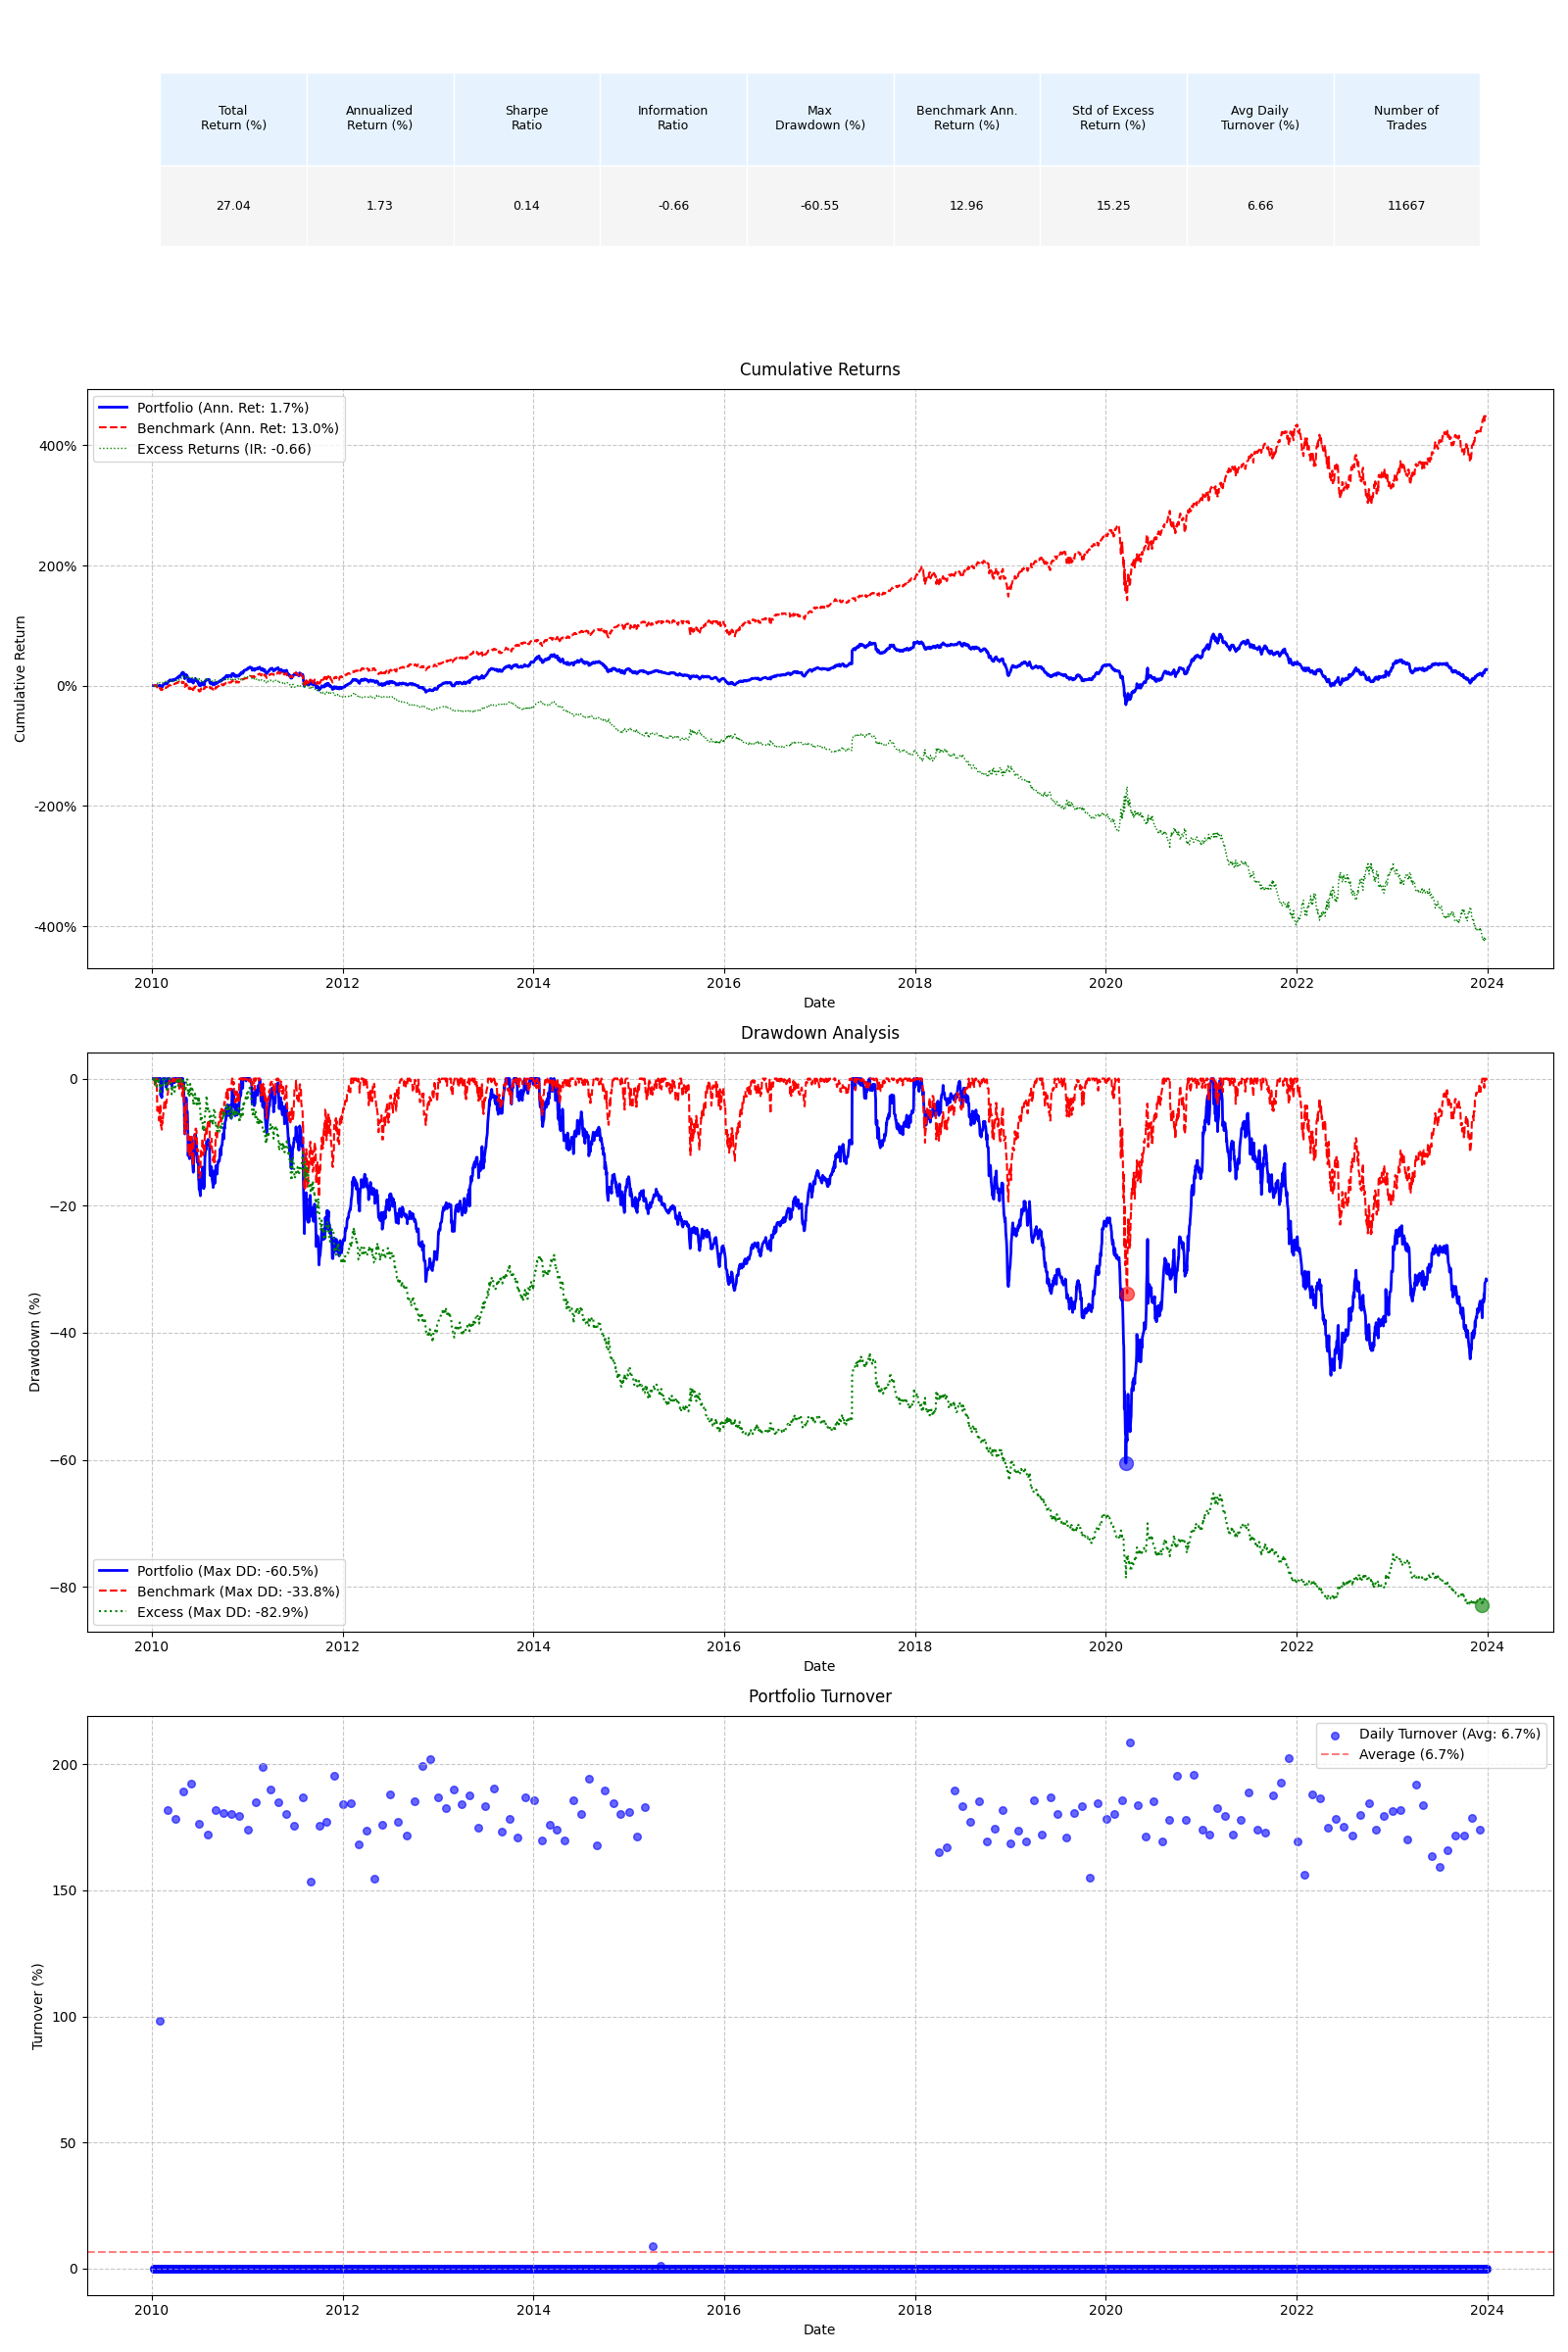

In [8]:
backtest.plot_performance_summary(interactive=True)
plt.show()

In [9]:
backtest.save_performance_summary_pdfs(output_dir='backtest_results',
    dpi=2400)

PDF files have been saved to backtest_results/:
├── 1_metrics_table.pdf
├── 2_cumulative_returns.pdf
├── 3_drawdown_analysis.pdf
└── 4_turnover_analysis.pdf


In [10]:
# Example buy and hold portfolio
'''
buy_and_hold_test_C2 = {
    14593: 0.4,
    16437: 0.2,
    14450: 0.2,
    89349: 0.2,
#2020-06-01-2020-08-31
}
buy_and_hold_test_CS = {
    14593: 0.4,
    80711: 0.2,
    75152: 0.1,
    15950: 0.1, 
    14252: 0.1,
    25129: 0.1
#2020-11-01-2020-12-31
}
buy_and_hold_test_M2MU = {
    14593: 0.1,
    18790:0.1,
    89942:0.1,
    16836:0.1,
    89901:0.1,
    17016:0.1,
    92910:0.1,
    10065:0.1,
    15282:0.1,
    91278:0.1
#2020-09-01-2020-12-31
}
buy_and_hold_test_O1P1 = {
    14593: 0.5,
    49680:0.1,
    26825:0.1,
    88233:0.1,
    17250:0.1,
    88901:0.1
#2023-09-01-2023-11-30
}
buy_and_hold_D1D2 = {
    14593: 0.4,
    12413:0.1,
    13191:0.1,
    81560:0.1,
    90499:0.1,
    20807:0.1,
    14433:0.1
#2022-03-01-2022-04-30
}
buy_and_hold_suspended = {
    14593: 0.4,
    20740: 0.2,
    21847: 0.2,
    14127: 0.2
#2021-11-01-2023-04-30
}
buy_and_hold = {
    14593: 0.4,
    20740: 0.2,
    21847: 0.2,
    14127: 0.2,
    16437: 0.2,
    14450: 0.2,
    89349: 0.2,
    12413:0.1,
    13191:0.1,
    81560:0.1,
    90499:0.1,
    20807:0.1,
    14433:0.1,
    49680:0.1,
    26825:0.1,
    88233:0.1,
    17250:0.1,
    88901:0.1,
    18790:0.1,
    89942:0.1,
    16836:0.1,
    89901:0.1,
    17016:0.1,
    92910:0.1,
    10065:0.1,
    15282:0.1,
    91278:0.1,
    80711: 0.2,
    75152: 0.1,
    15950: 0.1, 
    14252: 0.1,
    25129: 0.1,
#2021-11-01-2023-04-30
}
'''


'\nbuy_and_hold_test_C2 = {\n    14593: 0.4,\n    16437: 0.2,\n    14450: 0.2,\n    89349: 0.2,\n#2020-06-01-2020-08-31\n}\nbuy_and_hold_test_CS = {\n    14593: 0.4,\n    80711: 0.2,\n    75152: 0.1,\n    15950: 0.1, \n    14252: 0.1,\n    25129: 0.1\n#2020-11-01-2020-12-31\n}\nbuy_and_hold_test_M2MU = {\n    14593: 0.1,\n    18790:0.1,\n    89942:0.1,\n    16836:0.1,\n    89901:0.1,\n    17016:0.1,\n    92910:0.1,\n    10065:0.1,\n    15282:0.1,\n    91278:0.1\n#2020-09-01-2020-12-31\n}\nbuy_and_hold_test_O1P1 = {\n    14593: 0.5,\n    49680:0.1,\n    26825:0.1,\n    88233:0.1,\n    17250:0.1,\n    88901:0.1\n#2023-09-01-2023-11-30\n}\nbuy_and_hold_D1D2 = {\n    14593: 0.4,\n    12413:0.1,\n    13191:0.1,\n    81560:0.1,\n    90499:0.1,\n    20807:0.1,\n    14433:0.1\n#2022-03-01-2022-04-30\n}\nbuy_and_hold_suspended = {\n    14593: 0.4,\n    20740: 0.2,\n    21847: 0.2,\n    14127: 0.2\n#2021-11-01-2023-04-30\n}\nbuy_and_hold = {\n    14593: 0.4,\n    20740: 0.2,\n    21847: 0.2,\n  